# Install Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats

from datetime import datetime
from dateutil.parser import parse

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Part 1: Data Exploration and Evaluation

# Load Data

In [2]:
loan = pd.read_csv('loan.csv')

In [3]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Search for Primary Keys
#id := unique LC id for loan listing
#member_id := unique LC id for the borrower member
sum_stats = loan[['id','member_id']].describe(include='all')

In [5]:
#However, both of those fields are fully null...
(sum_stats.loc['count',:]/loan.shape[0])*100

id           0.0
member_id    0.0
Name: count, dtype: float64

# Subset Columns

In [6]:
#Feature Set (shortened descriptions from LCDataDictionary.xlsx)
#loan_amnt := listed amount of the loan applied for by the borrower (if reduced it will be reflected)
#funded_amnt := total amount committed to that loan (point in time)
#term := number of payments on the loan (values in months, 36 or 60)
#int_rate := interest rate on the loan
#grade := LC assigned loan grade
#annual_inc := annual income (self-reported during registration)
#issue_d := month which the loan was funded
#dti := ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, 
#       excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income
#revol_bal := total credit revolving balance
#total_pymnt := payments received to date for total amount funded
#loan_status := current status of the loan
loan_db = loan[['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 
                'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']]

# Summary Stats

In [7]:
loan_db.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,2.26067e+06,NaN,NaN,NaN,15046.9,9190.25,500,8000,12900,20000,40000
funded_amnt,2.26067e+06,NaN,NaN,NaN,15041.7,9188.41,500,8000,12875,20000,40000
term,2260668,2,36 months,1609754,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,2.26067e+06,NaN,NaN,NaN,13.0929,4.83211,5.31,9.49,12.62,15.99,30.99
grade,2260668,7,B,663557,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,2.26066e+06,NaN,NaN,NaN,77992.4,112696,0,46000,65000,93000,1.1e+08
issue_d,2260668,139,Mar-2016,61992,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dti,2.25896e+06,NaN,NaN,NaN,18.8242,14.1833,-1,11.89,17.84,24.49,999
revol_bal,2.26067e+06,NaN,NaN,NaN,16658.5,22948.3,0,5950,11324,20246,2.90484e+06
total_pymnt,2.26067e+06,NaN,NaN,NaN,11824,9889.6,0,4272.58,9060.87,16708,63296.9


In [8]:
print('Total Rows: '+str(loan_db.shape[0]))

Total Rows: 2260668


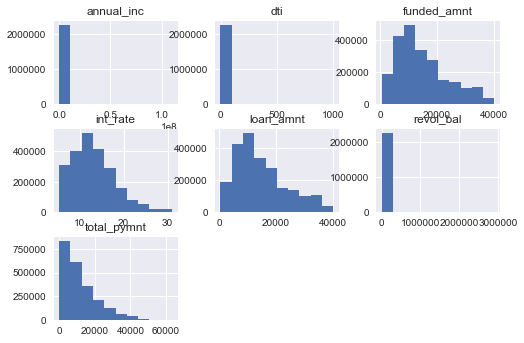

In [9]:
loan_db.hist()
plt.show()

# Column Exploration

# Observatons Over Time

In [10]:
issue_date = loan_db['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%Y')).to_frame()

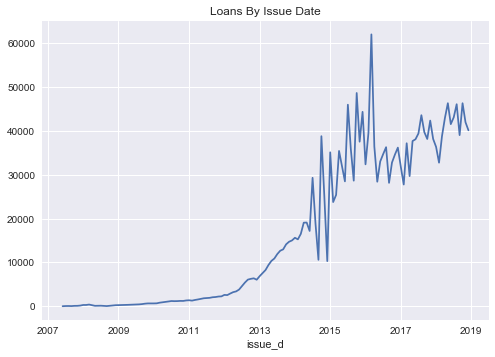

In [11]:
issue_date.groupby(['issue_d'])['issue_d'].count().plot()
plt.title('Loans By Issue Date')
plt.show()

# Income

From the summary statistics we know we have both 0 values as well as high outliers

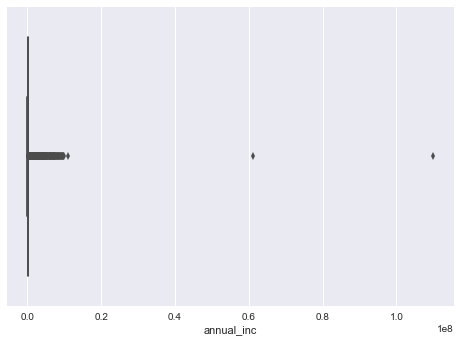

In [12]:
sns.boxplot(x=loan_db[loan_db['annual_inc'].notnull()]['annual_inc'])
plt.show()

First we remove the data points above the 99th percentile and below the 1st percentile

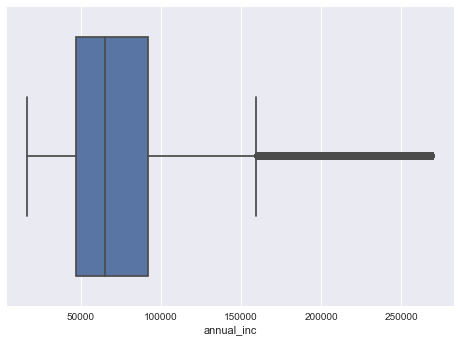

In [13]:
sns.boxplot(x=loan_db[(loan_db['annual_inc'].notnull()) & 
                      (loan_db['annual_inc'] <= loan_db.annual_inc.quantile(.99)) &
                      (loan_db['annual_inc'] >= loan_db.annual_inc.quantile(.01))
                     ]['annual_inc'])
plt.show()

We also know that logging income will make the variable more normally distributed

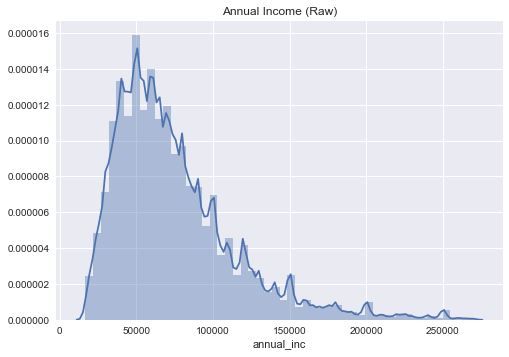

In [14]:
sns.distplot(loan_db[(loan_db['annual_inc'].notnull()) & 
                     (loan_db['annual_inc'] <= loan_db.annual_inc.quantile(.99)) &
                     (loan_db['annual_inc'] >= loan_db.annual_inc.quantile(.01)) &
                     (loan_db['annual_inc'] > 0)]['annual_inc'])
plt.title('Annual Income (Raw)')
plt.show()


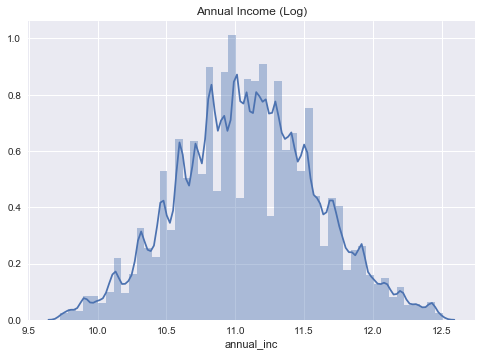

In [15]:
sns.distplot(np.log(loan_db[(loan_db['annual_inc'].notnull()) & 
                     (loan_db['annual_inc'] <= loan_db.annual_inc.quantile(.99)) &
                     (loan_db['annual_inc'] >= loan_db.annual_inc.quantile(.01)) &
                     (loan_db['annual_inc'] > 0)]['annual_inc']))
plt.title('Annual Income (Log)')
plt.show()

# Apply the filter to the data

In [16]:
loan_db_filtered = loan_db[(loan_db['annual_inc'].notnull()) & 
                           (loan_db['annual_inc'] <= loan_db.annual_inc.quantile(.99)) &
                           (loan_db['annual_inc'] >= loan_db.annual_inc.quantile(.01)) &
                           (loan_db['annual_inc'] > 0)].reset_index(drop=True)

In [17]:
loan_db_filtered.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,2.21558e+06,NaN,NaN,NaN,14993.1,9088.38,500,8000,12800,20000,40000
funded_amnt,2.21558e+06,NaN,NaN,NaN,14987.8,9086.53,500,8000,12800,20000,40000
term,2215576,2,36 months,1574368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,2.21558e+06,NaN,NaN,NaN,13.0912,4.82524,5.31,9.49,12.62,15.99,30.99
grade,2215576,7,B,651630,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,2.21558e+06,NaN,NaN,NaN,74845.8,40053.9,16800,47000,65000,92000,270000
issue_d,2215576,139,Mar-2016,60928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dti,2.21558e+06,NaN,NaN,NaN,18.6217,9.30313,-1,11.98,17.9,24.5,581.61
revol_bal,2.21558e+06,NaN,NaN,NaN,16239.8,19821,0,5994,11333.5,20117,1.47094e+06
total_pymnt,2.21558e+06,NaN,NaN,NaN,11812.5,9822.19,0,4314.53,9105.59,16677.1,63296.9


In [18]:
print('Total Rows: '+str(loan_db_filtered.shape[0]))

Total Rows: 2215576


# Debt to Income (DTI)

To filter DTI we know these values should be >= 0; however we cannot make any assumptions on the high end without knowing things like savings or average daily bank balance. While it is most sensible for DTI to be < 100 it is possible people over extend themselves or are borrowing against savings. 

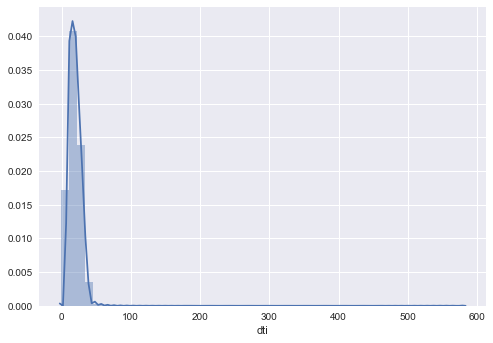

In [19]:
sns.distplot(loan_db_filtered['dti'])
plt.show()

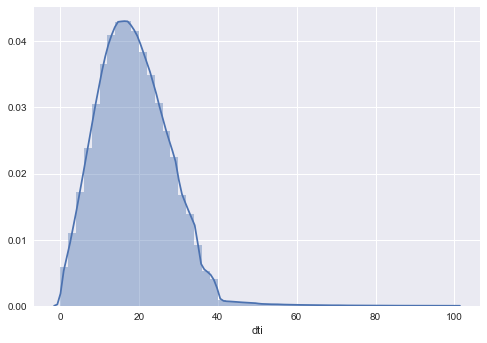

In [20]:
sns.distplot(loan_db_filtered[(loan_db_filtered['dti']>=0) &
                              (loan_db_filtered['dti']<=100)]['dti'])
plt.show()

# Apply the filter to the data

In [21]:
loan_db_filtered = loan_db_filtered[loan_db_filtered['dti']>=0].reset_index(drop=True)

# Categorical Variables

In [22]:
loan_db_filtered.groupby(['term'])['loan_status'].count()

term
 36 months    1574367
 60 months     641207
Name: loan_status, dtype: int64

In [23]:
loan_db_filtered.groupby(['grade'])['loan_status'].count()

grade
A    423234
B    651629
C    637721
D    317433
E    132645
F     41019
G     11893
Name: loan_status, dtype: int64

In [24]:
loan_db_filtered.groupby(['loan_status'])['loan_status'].count()

loan_status
Charged Off                                             257576
Current                                                 896878
Default                                                     31
Does not meet the credit policy. Status:Charged Off        722
Does not meet the credit policy. Status:Fully Paid        1880
Fully Paid                                             1024766
In Grace Period                                           8734
Late (16-30 days)                                         3620
Late (31-120 days)                                       21367
Name: loan_status, dtype: int64

Explanation of each loan status:
Charged Off := after a loan has been defaulted; declaration an amount of debt is unlikely to be collected
Does not meet the credit policy. Status:Charged Off

Default := one or more payments are overdue but it has not been formally charged off
Other Indicators that a loan is still in progress...Late (16-30 days), Late (31-120 days), In Grace Period

Current := one or more payments completed; no payments past due; loan has one or more scheduled future payments

Fully Paid := repaid in full including all principal and interest payments
Does not meet the credit policy. Status:Fully Paid 

# Part 2: Business Analysis

Evaluating whether the 36 month term loans would make for a good investment
Assume a 36 month investment period for each loan, and exclude loans with less than 36 months of data available

In [25]:
loan_db_part2 = loan_db_filtered

In [26]:
#Turn issue date into a date variable to grab origination year
loan_db_part2['issue_date'] = loan_db_part2['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%Y'))
loan_db_part2['Origination_Year'] = loan_db_part2.issue_date.apply(lambda x: x.year)

# Further Filtering

In [27]:
#Filter for 36 month term
loan_db_part2 = loan_db_part2[loan_db_part2.term == ' 36 months'].reset_index(drop=True)

#Filter to loans originated over 36 months ago
loan_db_part2 = loan_db_part2[loan_db_part2.Origination_Year <= 2015].reset_index(drop=True)

In [28]:
loan_db_part2.groupby(['loan_status'])['loan_status'].count()

loan_status
Charged Off                                             84251
Current                                                   121
Does not meet the credit policy. Status:Charged Off       610
Does not meet the credit policy. Status:Fully Paid       1685
Fully Paid                                             523731
In Grace Period                                            15
Late (16-30 days)                                           4
Late (31-120 days)                                        174
Name: loan_status, dtype: int64

In [32]:
# Simplify Loan Status into a smaller subset of Outcomes
def loan_status_unification(status):
    if (status == 'Charged Off') or (status == 'Does not meet the credit policy. Status:Charged Off'):
        return 'Charged Off'
    elif (status == 'Fully Paid') or (status == 'Does not meet the credit policy. Status:Fully Paid'):
        return 'Fully Paid'
    else: 
        return status
loan_db_part2['outcome'] = loan_db_part2['loan_status'].apply(lambda x: loan_status_unification(x))

In [33]:
# In this scenario a loan is either fully paid (0) or in default (1)
def default_indicator(status):
    if (status == 'Fully Paid') or (status == 'Does not meet the credit policy. Status:Fully Paid'):
        return 0
    else:
        return 1
loan_db_part2['default_ind'] = loan_db_part2['loan_status'].apply(lambda x: default_indicator(x))

# 1) What percentage of loans has been fully paid?

In [34]:
outcomes = loan_db_part2.groupby(['outcome'])['outcome'].count().rename("count")
print(round((outcomes/outcomes.sum())*100,2))

outcome
Charged Off           13.90
Current                0.02
Fully Paid            86.05
In Grace Period        0.00
Late (16-30 days)      0.00
Late (31-120 days)     0.03
Name: count, dtype: float64


# 2) When bucketed by year of origination and grade, which cohort has the highest rate of defaults? Here you may assume that any loan which was not fully paid had “defaulted”.

# Origination Year

In [35]:
num_defaulted = loan_db_part2.groupby(['Origination_Year'])['default_ind'].sum().rename('defaulted').reset_index()
num_loans = loan_db_part2.groupby(['Origination_Year'])['default_ind'].count().rename('loans').reset_index()

In [36]:
loan_performance = pd.merge(num_defaulted, num_loans, on = ['Origination_Year'])
loan_performance['default_rate'] = round((loan_performance.defaulted/loan_performance.loans)*100,2)

In [37]:
loan_performance.sort_values(by=['Origination_Year'],ascending=False).reset_index(drop=True)

,Origination_Year,defaulted,loans,default_rate
0,2015,41532,277908,14.94
1,2014,21926,159947,13.71
2,2013,12186,99225,12.28
3,2012,5820,42843,13.58
4,2011,1458,13796,10.57
5,2010,948,8889,10.66
6,2009,692,5114,13.53
7,2008,480,2335,20.56
8,2007,133,534,24.91


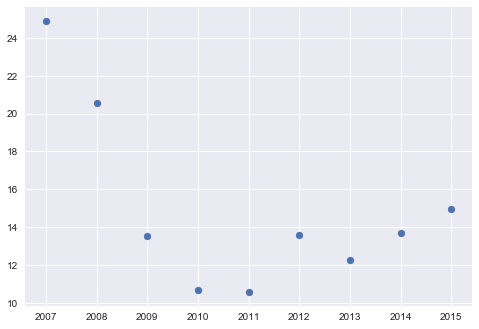

In [38]:
plt.scatter(loan_performance.Origination_Year,loan_performance.default_rate)
plt.show()

# Grade

In [39]:
num_defaulted = loan_db_part2.groupby(['grade'])['default_ind'].sum().rename('defaulted').reset_index()
num_loans = loan_db_part2.groupby(['grade'])['default_ind'].count().rename('loans').reset_index()

In [40]:
loan_performance = pd.merge(num_defaulted, num_loans, on = ['grade'])
loan_performance['default_rate'] = round((loan_performance.defaulted/loan_performance.loans)*100,2)

In [41]:
loan_performance.sort_values(by=['grade'],ascending=False).reset_index(drop=True)

,grade,defaulted,loans,default_rate
0,G,248,627,39.55
1,F,1408,4234,33.25
2,E,6033,20990,28.74
3,D,17542,74799,23.45
4,C,28685,159824,17.95
5,B,23517,209313,11.24
6,A,7742,140804,5.50


# Origination Year x Grade

In [42]:
num_defaulted = loan_db_part2.groupby(['Origination_Year','grade'])['default_ind'].sum().rename('defaulted').reset_index()
num_loans = loan_db_part2.groupby(['Origination_Year','grade'])['default_ind'].count().rename('loans').reset_index()

In [43]:
loan_performance = pd.merge(num_defaulted, num_loans, on = ['Origination_Year','grade'])
loan_performance['default_rate'] = round((loan_performance.defaulted/loan_performance.loans)*100,2)

In [44]:
loan_performance.sort_values(by=['default_rate'],ascending=False).reset_index(drop=True).head()

,Origination_Year,grade,defaulted,loans,default_rate
0,2015,G,107,221,48.42
1,2007,F,24,51,47.06
2,2007,G,13,29,44.83
3,2015,F,552,1292,42.72
4,2009,G,18,49,36.73


# 3) When bucketed by year of origination and grade, what annualized rate of return have these loans generated on average?

For simplicity, use the following approximation:
Annualized rate of return = (total_pymnt / funded_amnt) ^ (1/3) - 1

In [45]:
def annualized_return(row):
    return (((row['total_pymnt']/row['funded_amnt']) ** (1/3))-1)
loan_db_part2['annualized_rate_of_return'] = loan_db_part2.apply(annualized_return,axis=1)

# Overall

In [46]:
loan_db_part2['annualized_rate_of_return'].mean()*100

1.8995387407381437

# Origination Year

In [47]:
loan_db_part2.groupby(['Origination_Year'])['annualized_rate_of_return'].mean().reset_index()

,Origination_Year,annualized_rate_of_return
0,2007,-0.010923
1,2008,-0.003214
2,2009,0.014982
3,2010,0.021042
4,2011,0.018909
5,2012,0.021747
6,2013,0.028977
7,2014,0.022106
8,2015,0.013473


# Grade

In [48]:
loan_db_part2.groupby(['grade'])['annualized_rate_of_return'].mean().reset_index()

,grade,annualized_rate_of_return
0,A,0.020342
1,B,0.022933
2,C,0.017801
3,D,0.013222
4,E,0.005222
5,F,0.000699
6,G,-0.020074


# Origination Year x Grade

In [49]:
returns = loan_db_part2.groupby(['Origination_Year','grade'])['annualized_rate_of_return'].mean().reset_index()

In [78]:
returns['annualized_rate_of_return'].mean()*100

0.7896985290007618

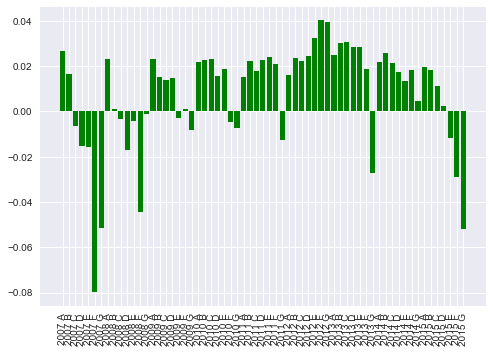

In [51]:
x = returns['Origination_Year'].map(str) + ' ' + returns['grade']
y = returns.annualized_rate_of_return

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xticks(x_pos, x,rotation='vertical')
plt.show()

# Part 3: Modeling

Please build a logistic regression model to predict loan defaults that could help us avoid investing in such loans. 

In [52]:
loan_db_part3 = loan_db_part2

In [53]:
#Filter to loans that are Fully Paid or Charged Off (Definite Outcomes)
loan_db_part3 = loan_db_part3[loan_db_part3['outcome'].isin(['Charged Off','Fully Paid'])].reset_index(drop=True)

In [54]:
from sklearn import preprocessing
number = preprocessing.LabelEncoder()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
rfe = RFE(logreg)

import statsmodels.api as sm

# Feature Creation

In [55]:
#Log the Income related variables
loan_db_part3['log_inc'] = np.log(loan_db_part3['annual_inc'])
loan_db_part3['log_revol_bal'] = np.log(loan_db_part3['revol_bal']+1)

#Turn Categorical into Numeric
loan_db_part3['grade_cat'] = number.fit_transform(loan_db_part3['grade'])

#Define Additional Features to test
loan_db_part3['diff_in_funding'] = loan_db_part3['funded_amnt'] - loan_db_part3['loan_amnt']

In [56]:
#Filter DB to relevant columns
model_df = loan_db_part3[['funded_amnt','diff_in_funding','int_rate',
                          'grade_cat','log_inc','dti','log_revol_bal',
                          'default_ind']]

In [57]:
#Confirm what the categorical looks like numerically
loan_db_part3.groupby(['grade','grade_cat'])['default_ind'].count()

grade  grade_cat
A      0            140771
B      1            209199
C      2            159734
D      3             74745
E      4             20973
F      5              4231
G      6               624
Name: default_ind, dtype: int64

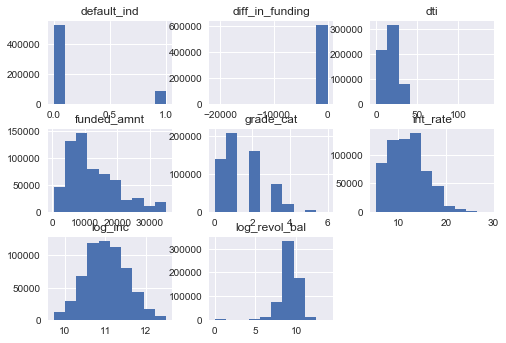

In [58]:
model_df.hist()
plt.show()

In [59]:
#scatter_matrix(model_df.sample(frac=0.25, replace=False, random_state=1), alpha=0.2, figsize=(6, 6), diagonal='kde')
model_df.corr()

,funded_amnt,diff_in_funding,int_rate,grade_cat,log_inc,dti,log_revol_bal,default_ind
funded_amnt,1.000000,0.007680,-0.084115,-0.083594,0.497529,0.011973,0.384587,-0.015184
diff_in_funding,0.007680,1.000000,0.015430,0.006199,-0.010732,0.016266,-0.002447,0.000158
int_rate,-0.084115,0.015430,1.000000,0.939436,-0.214134,0.138035,-0.096716,0.188700
grade_cat,-0.083594,0.006199,0.939436,1.000000,-0.204665,0.145428,-0.105439,0.193332
log_inc,0.497529,-0.010732,-0.214134,-0.204665,1.000000,-0.216139,0.317277,-0.087823
dti,0.011973,0.016266,0.138035,0.145428,-0.216139,1.000000,0.227523,0.080762
log_revol_bal,0.384587,-0.002447,-0.096716,-0.105439,0.317277,0.227523,1.000000,-0.029943
default_ind,-0.015184,0.000158,0.188700,0.193332,-0.087823,0.080762,-0.029943,1.000000


# Model Build

In [60]:
#Partition the data between the features and dependent variable
X = model_df.loc[:, model_df.columns != 'default_ind']
y = model_df.loc[:, model_df.columns == 'default_ind']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [61]:
#Use SMOTE to re-balance the sample
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)

In [62]:
os_data_X = pd.DataFrame(data=os_data_X,columns=['funded_amnt','diff_in_funding','int_rate',
                                                 'grade_cat','log_inc','dti','log_revol_bal'])
os_data_y= pd.DataFrame(data=os_data_y,columns=['default_ind'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no default in oversampled data",len(os_data_y[os_data_y['default_ind']==0]))
print("Number of default",len(os_data_y[os_data_y['default_ind']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['default_ind']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['default_ind']==1])/len(os_data_X))

length of oversampled data is  735980
Number of no default in oversampled data 367990
Number of default 367990
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [63]:
#Check what variable ranking suggests for relative importance
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())

In [64]:
print(rfe.ranking_)

[5 4 1 1 1 2 3]


In [68]:
#Select Variables to test
cols=['int_rate','grade_cat','log_inc','dti'] 

In [69]:
X=os_data_X[cols]
y=os_data_y['default_ind']

In [70]:
#Evaulate Variable Performance in Logistic Regression Model
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.648831
         Iterations 5
                          Results: Logit
Model:              Logit            No. Iterations:   5.0000     
Dependent Variable: default_ind      Pseudo R-squared: 0.064      
Date:               2019-11-17 10:16 AIC:              955061.5852
No. Observations:   735980           BIC:              955107.6210
Df Model:           3                Log-Likelihood:   -4.7753e+05
Df Residuals:       735976           LL-Null:          -5.1014e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
int_rate      0.0834    0.0019    44.8275  0.0000   0.0798   0.0871
grade_cat     0.2244    0.0064    34.9122  0.0000   0.2118   0.2370
log_inc      -0.1612    0.0014  -117.6452  0.000

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.63


In [73]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[69813 40176]
 [42073 68732]]


In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.63      0.63    109989
           1       0.63      0.62      0.63    110805

    accuracy                           0.63    220794
   macro avg       0.63      0.63      0.63    220794
weighted avg       0.63      0.63      0.63    220794



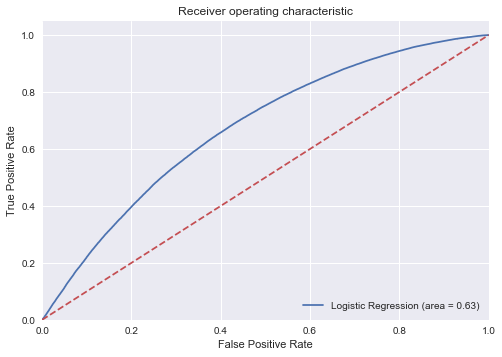

In [75]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test[cols]))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test[cols])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Confirm Robustness of Results with K Fold CV

In [76]:
kf = KFold(n_splits=10,shuffle=True)
X = model_df[cols]
y = model_df[['default_ind']]

scores = []
for i in range(10):
    result = next(kf.split(X), None)
    x_train = X.iloc[result[0]]
    x_test = X.iloc[result[1]]
    y_train = y.iloc[result[0]]
    y_test = y.iloc[result[1]]
    
    os_data_X,os_data_y=os.fit_sample(x_train, y_train)
    
    os_data_X = pd.DataFrame(data=os_data_X,columns=cols)
    os_data_y= pd.DataFrame(data=os_data_y,columns=['default_ind'])
  
    model = logreg.fit(os_data_X,os_data_y)
    predictions = logreg.predict(x_test)
    scores.append(model.score(x_test,y_test))
print('Scores from each Iteration: ', scores)
print('Average K-Fold Score :' , np.mean(scores))

Scores from each Iteration:  [0.6289244281313495, 0.6308743527561119, 0.627203906403618, 0.6259094186275153, 0.6260896637608966, 0.630710493543947, 0.6276627121976798, 0.6335452579144, 0.629006357737432, 0.6269253457429377]
Average K-Fold Score : 0.6286851936815887
